In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import numpy as np

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

def process_portfolio(portfolio_div, dripped_symbols=None, start_date='1993-01-29', end_date='2023-12-31', initial_investment=10000):
    all_dividends = pd.DataFrame()

    for symbol in portfolio_div:
        try:
            stock = yf.Ticker(symbol)

            # Fetch historical price data
            price_data = stock.history(start=start_date, end=end_date)
            price_data.reset_index(inplace=True)
            price_data['symbol'] = symbol

            # Fetch historical dividend data
            dividend_data = stock.dividends.reset_index()
            dividend_data.columns = ['Date', 'Dividend']
            dividend_data['Date'] = pd.to_datetime(dividend_data['Date'])
            dividend_data['symbol'] = symbol

            # Fetch historical stock splits data
            split_data = stock.splits.reset_index()
            split_data.columns = ['Date', 'Stock Splits']
            split_data['Date'] = pd.to_datetime(split_data['Date'])
            split_data['symbol'] = symbol

            # Merge price data with dividend and stock splits data
            combined_data = pd.merge(price_data, dividend_data, how='left', on=['Date', 'symbol'])
            combined_data = pd.merge(combined_data, split_data, how='left', on=['Date', 'symbol'])

            # Adjust historical prices and dividends for stock splits
            if 'Stock Splits' in combined_data.columns and combined_data['Stock Splits'].notna().any():
                combined_data['Adj Close'] = combined_data['Close']
                combined_data['Adj Dividend'] = combined_data['Dividend']
                last_split_ratio = 1

                for i in range(len(combined_data)):
                    split_ratio = combined_data.at[i, 'Stock Splits']
                    if pd.notna(split_ratio) and split_ratio != 0:
                        combined_data.loc[:i, 'Adj Close'] /= split_ratio
                        combined_data.loc[:i, 'Adj Dividend'] /= split_ratio
                        last_split_ratio *= split_ratio
                    combined_data.at[i, 'Adj Close'] *= last_split_ratio
                    combined_data.at[i, 'Adj Dividend'] *= last_split_ratio

            else:
                combined_data['Adj Close'] = combined_data['Close']
                combined_data['Adj Dividend'] = combined_data['Dividend']

            all_dividends = pd.concat([all_dividends, combined_data], ignore_index=True)

        except Exception as e:
            print(f"Failed to get data for {symbol}: {e}")

    all_dividends['Date'] = pd.to_datetime(all_dividends['Date'])

    # Adding DRIP logic
    if dripped_symbols is not None:
        all_dividends['DRIP'] = all_dividends['symbol'].apply(lambda x: 'yes' if x in dripped_symbols else 'no')
    else:
        all_dividends['DRIP'] = 'no'

    # Calculate reinvested dividends and additional shares
    all_dividends['Reinvested_Dividends'] = np.where(all_dividends['DRIP'] == 'yes', all_dividends['Dividend'], 0)
    all_dividends['Additional_Shares'] = all_dividends['Reinvested_Dividends'] / all_dividends['Adj Close']
    all_dividends['Total_Shares'] = all_dividends.groupby('symbol')['Additional_Shares'].cumsum()
    all_dividends['Initial_Shares'] = initial_investment / all_dividends.groupby('symbol')['Adj Close'].transform('first')
    all_dividends['Portfolio_Value'] = (all_dividends['Initial_Shares'] + all_dividends['Total_Shares']) * all_dividends['Adj Close']

    return all_dividends

# Example portfolios
portfolios = {
    'Portfolio_1': {'symbols': ['PG', 'GPC', 'EMR', 'CINF', 'KO'], 'dripped': {'PG', 'GPC', 'EMR'}},
    'Portfolio_2': {'symbols': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA'], 'dripped': {'AAPL', 'MSFT'}}
}

# Loop through each portfolio and process them
for portfolio_name, portfolio_data in portfolios.items():
    print(f"Processing {portfolio_name}...")
    portfolio_div = portfolio_data['symbols']
    dripped_symbols = portfolio_data['dripped']

    all_dividends = process_portfolio(portfolio_div, dripped_symbols)
    print(all_dividends.head())


Processing Portfolio_1...
                       Date      Open      High       Low     Close   Volume  \
0 1993-01-29 00:00:00-05:00  5.788132  5.802531  5.716141  5.730539  4040000   
1 1993-02-01 00:00:00-05:00  5.759337  5.802532  5.730540  5.788134  3292400   
2 1993-02-02 00:00:00-05:00  5.759336  5.816929  5.759336  5.759336  2364400   
3 1993-02-03 00:00:00-05:00  5.788135  5.845728  5.788135  5.831330  2091600   
4 1993-02-04 00:00:00-05:00  5.860127  5.888924  5.802534  5.860127  3082800   

   Dividends  Stock Splits_x symbol  Dividend  Stock Splits_y  Adj Close  \
0        0.0             0.0     PG       NaN             NaN   5.730539   
1        0.0             0.0     PG       NaN             NaN   5.788134   
2        0.0             0.0     PG       NaN             NaN   5.759336   
3        0.0             0.0     PG       NaN             NaN   5.831330   
4        0.0             0.0     PG       NaN             NaN   5.860127   

   Adj Dividend DRIP  Reinvested_Div

<ipython-input-3-14fbcc7b76bb>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1000.          1007.65268595  1008.92803578 ... 10875.33329271
 10970.34620881 10933.33981398]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']
<ipython-input-3-14fbcc7b76bb>:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1000.          1015.46467601  1017.1820542  ... 25780.81849076
 25417.63708046 25314.11008383]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']
<ipython-input-3-14fbcc7b76bb>:42: FutureWarning: Setting an item of incompatible dtype is deprecated an

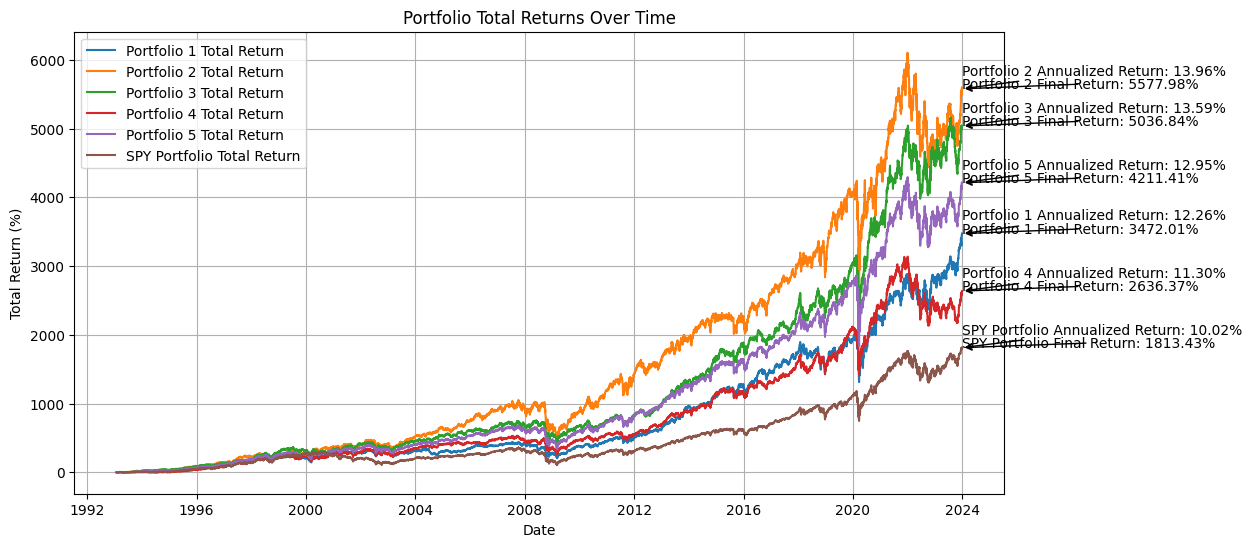

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess each portfolio
def preprocess_all_portfolios(portfolio_dict):
    portfolio_data_dict = {}
    for portfolio_name, portfolio_data in portfolio_dict.items():
        symbols = portfolio_data['symbols']
        dripped_symbols = portfolio_data.get('dripped')  # Use .get() to avoid KeyError
        portfolio_data = process_portfolio(symbols, dripped_symbols)
        portfolio_data_dict[portfolio_name] = portfolio_data
    return portfolio_data_dict

# Portfolio definition (adjusted to match the expected format)
portfolios = {
    'Portfolio 1': {'symbols': ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL']},
    'Portfolio 2': {'symbols': ['CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC']},
    'Portfolio 3': {'symbols': ['HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE']},
    'Portfolio 4': {'symbols': ['PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM', 'MMM']},
    'Portfolio 5': {'symbols': ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL',
           'CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC',
           'HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE',
           'PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM']},
    'SPY Portfolio': {'symbols': ['SPY']}
}

# Preprocess all portfolios
portfolio_data_dict = preprocess_all_portfolios(portfolios)

# Plot performance for each portfolio
def plot_portfolios(portfolio_data_dict):
    plt.figure(figsize=(12, 6))

    for portfolio_name, portfolio_data in portfolio_data_dict.items():
        initial_investment_per_stock = 10000 / len(portfolio_data['symbol'].unique())
        portfolio_data['normalized_value'] = 0

        for symbol in portfolio_data['symbol'].unique():
            stock_data = portfolio_data[portfolio_data['symbol'] == symbol].copy()  # Create a copy to avoid SettingWithCopyWarning
            initial_shares = initial_investment_per_stock / stock_data['Close'].iloc[0]
            stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Reinvested_Dividends'].cumsum() * initial_shares
            portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']

        portfolio_total = portfolio_data.groupby('Date')['normalized_value'].sum().reset_index()
        portfolio_total.rename(columns={'normalized_value': 'Total_Value'}, inplace=True)

        initial_value = portfolio_total['Total_Value'].iloc[0]
        portfolio_total['Total_Return'] = (portfolio_total['Total_Value'] / initial_value - 1) * 100

        start_value = portfolio_total['Total_Value'].iloc[0]
        end_value = portfolio_total['Total_Value'].iloc[-1]
        num_years = (portfolio_total['Date'].iloc[-1] - portfolio_total['Date'].iloc[0]).days / 365.25
        annualized_return = ((end_value / start_value) ** (1 / num_years) - 1) * 100

        plt.plot(portfolio_total['Date'], portfolio_total['Total_Return'], label=f'{portfolio_name} Total Return')

        total_return = portfolio_total['Total_Return'].iloc[-1]
        plt.annotate(f'{portfolio_name} Final Return: {total_return:.2f}%',
                     xy=(portfolio_total['Date'].iloc[-1], total_return),
                     xytext=(portfolio_total['Date'].iloc[-1], total_return + 10),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='black')

        plt.annotate(f'{portfolio_name} Annualized Return: {annualized_return:.2f}%',
                     xy=(portfolio_total['Date'].iloc[-1], total_return),
                     xytext=(portfolio_total['Date'].iloc[-1], total_return + 200),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='black')

    plt.title('Portfolio Total Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function
plot_portfolios(portfolio_data_dict)


In [4]:
def plot_portfolios(portfolio_data_dict):
    plt.figure(figsize=(12, 6))
    total_return_data = {}

    for portfolio_name, portfolio_data in portfolio_data_dict.items():
        # Normalize initial investment for each portfolio
        initial_investment_per_stock = 10000 / len(portfolio_data['symbol'].unique())
        portfolio_data['normalized_value'] = 0

        # Calculate normalized value for each stock in the portfolio
        for symbol in portfolio_data['symbol'].unique():
            stock_data = portfolio_data[portfolio_data['symbol'] == symbol]
            initial_shares = initial_investment_per_stock / stock_data['Close'].iloc[0]
            stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Reinvested_Dividends'].cumsum() * initial_shares
            portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']

        # Aggregate portfolio total value
        portfolio_total = portfolio_data.groupby('Date')['normalized_value'].sum().reset_index()
        portfolio_total.rename(columns={'normalized_value': 'Total_Value'}, inplace=True)

        # Calculate total return as a percentage
        initial_value = portfolio_total['Total_Value'].iloc[0]
        portfolio_total['Total_Return'] = (portfolio_total['Total_Value'] / initial_value - 1) * 100

        # Store total return data
        total_return_data[portfolio_name] = portfolio_total.set_index('Date')['Total_Return']

        # Calculate annualized return
        start_value = portfolio_total['Total_Value'].iloc[0]
        end_value = portfolio_total['Total_Value'].iloc[-1]
        num_years = (portfolio_total['Date'].iloc[-1] - portfolio_total['Date'].iloc[0]).days / 365.25
        annualized_return = ((end_value / start_value) ** (1 / num_years) - 1) * 100

        # Plot the portfolio's total return
        plt.plot(portfolio_total['Date'], portfolio_total['Total_Return'], label=f'{portfolio_name} Total Return')

        # Annotate final total return values and annualized returns
        total_return = portfolio_total['Total_Return'].iloc[-1]
        plt.annotate(f'{portfolio_name} Final Return: {total_return:.2f}%',
                     xy=(portfolio_total['Date'].iloc[-1], total_return),
                     xytext=(portfolio_total['Date'].iloc[-1], total_return + 10),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='black')

        plt.annotate(f'{portfolio_name} Annualized Return: {annualized_return:.2f}%',
                     xy=(portfolio_total['Date'].iloc[-1], total_return),
                     xytext=(portfolio_total['Date'].iloc[-1], total_return + 150),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='black')

    # Plot formatting
    plt.title('Portfolio Total Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return total_return_data


<ipython-input-4-1cbd3afd1bcb>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Reinvested_Dividends'].cumsum() * initial_shares
<ipython-input-4-1cbd3afd1bcb>:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1000.          1007.65268595  1008.92803578 ... 10875.33329271
 10970.34620881 10933.33981398]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']
<ipython-input-4-1cbd3afd1bcb>:14: SettingWithCopyWarning: 
A value is trying 

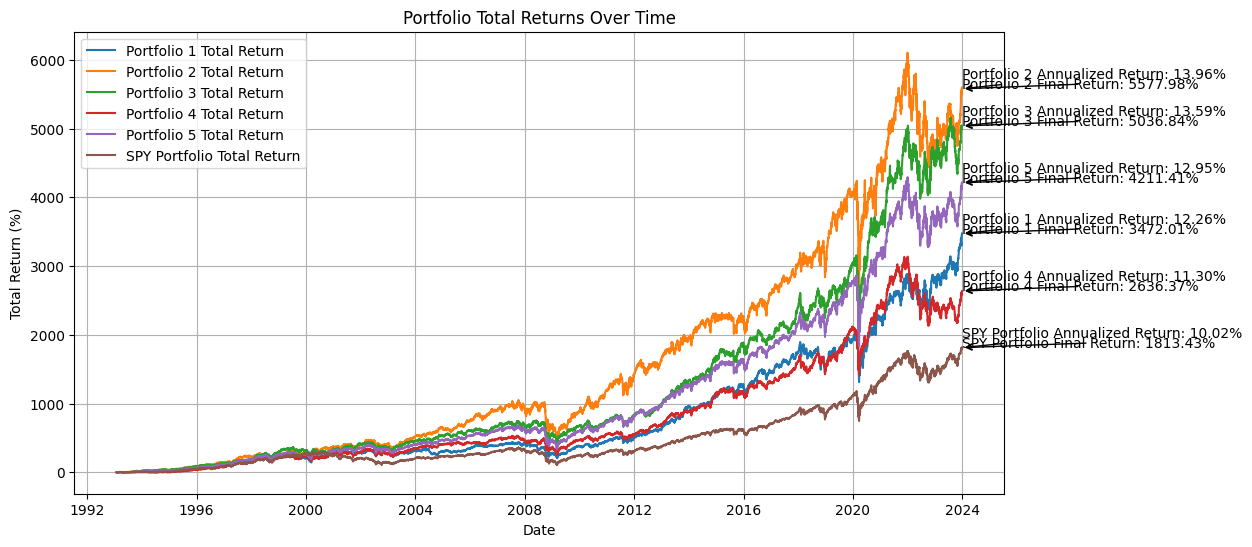

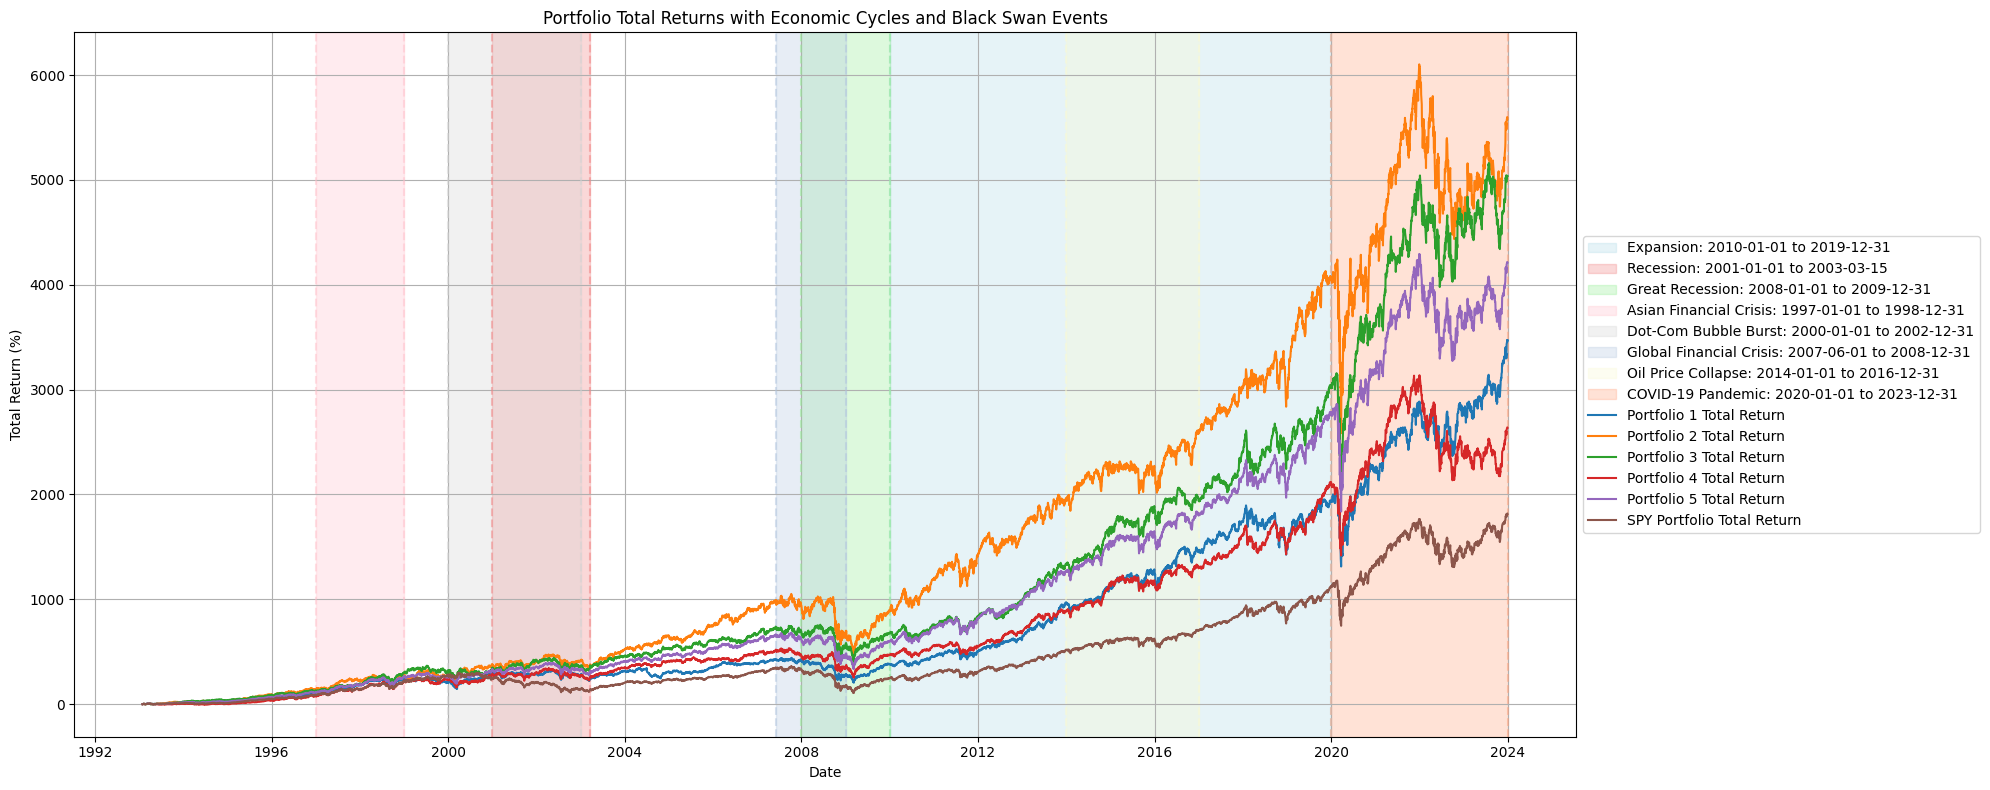

In [5]:
# Define economic cycles and Black Swan events
cycles = {
    'Expansion': ('1993-01-01', '2000-12-31'),
    'Recession': ('2001-01-01', '2003-03-15'),
    'Expansion': ('2003-01-01', '2007-12-31'),
    'Great Recession': ('2008-01-01', '2009-12-31'),
    'Expansion': ('2010-01-01', '2019-12-31'),
}

events = {
    'Asian Financial Crisis': ('1997-01-01', '1998-12-31'),
    'Dot-Com Bubble Burst': ('2000-01-01', '2002-12-31'),
    'Global Financial Crisis': ('2007-06-01', '2008-12-31'),
    'Oil Price Collapse': ('2014-01-01', '2016-12-31'),
    'COVID-19 Pandemic': ('2020-01-01', '2023-12-31'),
}

# Define a color palette for the shading
cycle_colors = {
    'Expansion': 'lightblue',
    'Recession': 'lightcoral',
    'Great Recession': 'lightgreen',
    'Asian Financial Crisis': 'pink',
    'Dot-Com Bubble Burst': 'lightgray',
    'Global Financial Crisis': 'lightsteelblue',
    'Oil Price Collapse': 'lightgoldenrodyellow',
    'COVID-19 Pandemic': 'lightsalmon',
}

# Function to format date ranges for legends
def format_date_range(start_date, end_date):
    return f'{pd.Timestamp(start_date).strftime("%Y-%m-%d")} to {pd.Timestamp(end_date).strftime("%Y-%m-%d")}'

# Define the function to annotate periods with labels and shading
def annotate_periods_with_labels_and_shading(df, periods):
    for label, (start_date, end_date) in periods.items():
        color = cycle_colors.get(label, 'gray')  # Default to gray if color is not found
        date_range = format_date_range(start_date, end_date)
        plt.axvspan(pd.Timestamp(start_date), pd.Timestamp(end_date), color=color, alpha=0.3, label=f'{label}: {date_range}' if label not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.axvline(pd.Timestamp(start_date), color=color, linestyle='--', alpha=0.5)
        plt.axvline(pd.Timestamp(end_date), color=color, linestyle='--', alpha=0.5)
        # Add label for start date
        plt.text(pd.Timestamp(start_date), df.min(), label, rotation=90, verticalalignment='bottom', horizontalalignment='right', fontsize=8, color='black')
        # Add label for end date
        plt.text(pd.Timestamp(end_date), df.max(), label, rotation=270, verticalalignment='top', horizontalalignment='left', fontsize=8, color='black')

# Call the plot function and get total return data
total_return_data = plot_portfolios(portfolio_data_dict)

# Create the base plot with economic cycles and events
plt.figure(figsize=(20, 8))

# Plot economic cycles and events
annotate_periods_with_labels_and_shading(pd.Series(), cycles)  # Provide an empty Series for correct axis limits
annotate_periods_with_labels_and_shading(pd.Series(), events)  # Provide an empty Series for correct axis limits

# Plot total returns for each portfolio
for portfolio_name, returns in total_return_data.items():
    plt.plot(returns.index, returns, label=f'{portfolio_name} Total Return')

# Plot formatting
plt.title('Portfolio Total Returns with Economic Cycles and Black Swan Events')
plt.xlabel('Date')
plt.ylabel('Total Return (%)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()  # Adjust layout to make sure nothing is cut off
plt.show()


In [7]:
# Function to calculate returns and generate table outside the plot function
def generate_returns_table(portfolio_data_dict):
    table_data = []

    for portfolio_name, portfolio_data in portfolio_data_dict.items():
        initial_investment_per_stock = 10000 / len(portfolio_data['symbol'].unique())
        portfolio_data['normalized_value'] = 0

        for symbol in portfolio_data['symbol'].unique():
            stock_data = portfolio_data[portfolio_data['symbol'] == symbol].copy()
            initial_shares = initial_investment_per_stock / stock_data['Close'].iloc[0]
            stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Reinvested_Dividends'].cumsum() * initial_shares
            portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']

        portfolio_total = portfolio_data.groupby('Date')['normalized_value'].sum().reset_index()
        portfolio_total.rename(columns={'normalized_value': 'Total_Value'}, inplace=True)

        # Calculate total and annualized returns
        initial_value = portfolio_total['Total_Value'].iloc[0]
        end_value = portfolio_total['Total_Value'].iloc[-1]
        total_return = (end_value / initial_value - 1) * 100

        num_years = (portfolio_total['Date'].iloc[-1] - portfolio_total['Date'].iloc[0]).days / 365.25
        annualized_return = ((end_value / initial_value) ** (1 / num_years) - 1) * 100

        # Append data to the table
        table_data.append({
            'Portfolio': portfolio_name,
            'Annualized Return (%)': annualized_return,
            'Total Return (%)': total_return
        })

    # Create and return the table as a pandas DataFrame
    returns_table = pd.DataFrame(table_data)
    return returns_table

# Call this new function after your original plotting code
returns_table = generate_returns_table(portfolio_data_dict)

# Display the table
print(returns_table)

<ipython-input-7-afe2bfc2f9e6>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1000.          1007.65268595  1008.92803578 ... 10875.33329271
 10970.34620881 10933.33981398]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']
<ipython-input-7-afe2bfc2f9e6>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1000.          1015.46467601  1017.1820542  ... 25780.81849076
 25417.63708046 25314.11008383]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']
<ipython-input-7-afe2bfc2f9e6>:13: FutureWarning: Setting an item of incompatible dtype is deprecated an

       Portfolio  Annualized Return (%)  Total Return (%)
0    Portfolio 1              12.262527       3472.008867
1    Portfolio 2              13.958317       5577.982815
2    Portfolio 3              13.589692       5036.841808
3    Portfolio 4              11.298887       2636.365895
4    Portfolio 5              12.947838       4211.407870
5  SPY Portfolio              10.018343       1813.434765


<ipython-input-7-afe2bfc2f9e6>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 10000.          10071.12581514  10092.47252305 ... 191826.57070925
 191899.01939285 191343.47645812]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value']


In [6]:

def get_dividend_history(symbol, start_date):
    stock = yf.Ticker(symbol)
    dividends = stock.dividends.loc[start_date:]
    return dividends

def is_dividend_aristocrat(symbol, years_required=20):
    try:
        dividends = get_dividend_history(symbol, start_date='2003-12-31')  # Adjust the start date as needed
        if dividends.index[-1].year >= (pd.Timestamp.today().year - years_required):
            return True
        else:
            return False
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return False

# Example usage
symbols = [
    'ACE', 'ABT', 'ANF', 'ACN', 'ADBE', 'AMD', 'AES', 'AET', 'AFL', 'A',
    'GAS', 'APD', 'ARG', 'AKAM', 'AA', 'ALXN', 'ATI', 'AGN', 'ALL', 'ANR',
    'ALTR', 'MO', 'AMZN', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AMP', 'ABC',
    'AMGN', 'APH', 'APC', 'ADI', 'AON', 'APA', 'AIV', 'APOL', 'AAPL', 'AMAT',
    'AIZ', 'ADSK', 'ADP', 'AN', 'AZO', 'AVB', 'AVY', 'AVP', 'BHI', 'BLL',
    'BAC', 'BK', 'BCR', 'BAX', 'BBT', 'BEAM', 'BDX', 'BBBY', 'BMS', 'BRK.B',
    'BBY', 'BIG', 'BIIB', 'BLK', 'HRB', 'BMC', 'BA', 'BWA', 'BXP', 'BSX',
    'BMY', 'BRCM', 'BF.B', 'CHRW', 'CA', 'CVC', 'COG', 'CAM', 'CPB', 'COF',
    'CFN', 'KMX', 'CCL', 'CAT', 'CBG', 'CBS', 'CELG', 'CNP', 'CTL', 'CERN',
    'CF', 'SCHW', 'CHK', 'CMG', 'CB', 'CI', 'CTXS', 'CLF', 'CLX', 'CME',
    'CMS', 'COH', 'CCE', 'CTSH', 'CMCSA', 'CMA', 'CSC', 'CAG', 'COP', 'CNX',
    'ED', 'STZ', 'CBE', 'GLW', 'COST', 'CVH', 'COV', 'CCI', 'CSX', 'CMI',
    'CVS', 'DHI', 'DHR', 'DRI', 'DVA', 'DF', 'DE', 'DELL', 'DNR', 'XRAY',
    'DVN', 'DV', 'DO', 'DTV', 'DFS', 'DISCA', 'DLTR', 'D', 'RRD', 'DOW',
    'DPS', 'DTE', 'DD', 'DUK', 'DNB', 'ETFC', 'EMN', 'ETN', 'EBAY', 'EIX',
    'EA', 'EMC', 'ESV', 'ETR', 'EOG', 'EQT', 'EFX', 'EQR', 'EL', 'EXC',
    'EXPE', 'EXPD', 'ESRX', 'FFIV', 'FDO', 'FII', 'FDX', 'FIS', 'FHN',
    'FSLR', 'FE', 'FISV', 'FLIR', 'FLS', 'FLR', 'FMC', 'FTI', 'F', 'FRX',
    'FOSL', 'FCX', 'FTR', 'GME', 'GCI', 'GPS', 'GE', 'GIS', 'GNW', 'GILD',
    'GS', 'GT', 'GOOG', 'GWW', 'HAL', 'HOG', 'HAR', 'HRS', 'HIG', 'HAS',
    'HCP', 'HCN', 'HNZ', 'HP', 'HES', 'HPQ', 'HD', 'HON', 'HSP', 'HST',
    'HCBK', 'HUM', 'HBAN', 'IR', 'TEG', 'INTC', 'ICE', 'IBM', 'IFF', 'IGT',
    'IP', 'IPG', 'INTU', 'ISRG', 'IVZ', 'IRM', 'JBL', 'JEC', 'JDSU', 'JCI',
    'JOY', 'JPM', 'JNPR', 'K', 'KEY', 'KMB', 'KIM', 'KMI', 'KLAC', 'KSS',
    'KFT', 'KR', 'LLL', 'LH', 'LRCX', 'LM', 'LEG', 'LEN', 'LUK', 'LXK',
    'LIFE', 'LLY', 'LTD', 'LNC', 'LLTC', 'LMT', 'L', 'LO', 'LSI', 'MTB',
    'MRO', 'MPC', 'MAR', 'MMC', 'MAS', 'MA', 'MAT', 'MKC', 'MHP', 'MCK',
    'MJN', 'MWV', 'MRK', 'MET', 'PCS', 'MCHP', 'MU', 'MSFT', 'MOLX', 'TAP',
    'MON', 'MNST', 'MCO', 'MS', 'MOS', 'MSI', 'MUR', 'MYL', 'NBR', 'NDAQ',
    'NOV', 'NTAP', 'NFLX', 'NWL', 'NFX', 'NEM', 'NWSA', 'NEE', 'NKE',
    'NI', 'NE', 'NBL', 'JWN', 'NSC', 'NTRS', 'NOC', 'NU', 'NRG', 'NUE',
    'NVDA', 'NYX', 'ORLY', 'OXY', 'OMC', 'OKE', 'ORCL', 'OI', 'PCAR',
    'PLL', 'PH', 'PDCO', 'PAYX', 'BTU', 'JCP', 'PBCT', 'POM', 'PKI', 'PRGO',
    'PFE', 'PCG', 'PM', 'PSX', 'PNW', 'PXD', 'PBI', 'PCL', 'PNC', 'RL',
    'PPG', 'PPL', 'PX', 'PCP', 'PCLN', 'PFG', 'PGR', 'PLD', 'PRU', 'PEG',
    'PSA', 'PHM', 'QEP', 'PWR', 'QCOM', 'DGX', 'RRC', 'RTN', 'RHT', 'RF',
    'RSG', 'RAI', 'RHI', 'ROK', 'COL', 'ROP', 'ROST', 'RDC', 'R', 'SWY',
    'SAI', 'CRM', 'SNDK', 'SCG', 'SLB', 'SNI', 'STX', 'SEE', 'SHLD', 'SRE',
    'SHW', 'SIAL', 'SPG', 'SLM', 'SJM', 'SNA', 'SO', 'LUV', 'SWN', 'SE',
    'S', 'STJ', 'SPLS', 'SBUX', 'HOT', 'STT', 'SRCL', 'SYK', 'SUN', 'STI',
    'SYMC', 'TROW', 'TEL', 'TE', 'THC', 'TDC', 'TER', 'TSO', 'TXN', 'TXT',
    'HSY', 'TRV', 'TMO', 'TIF', 'TWX', 'TWC', 'TIE', 'TJX', 'TMK', 'TSS',
    'TRIP', 'TSN', 'TYC', 'USB', 'UNP', 'UNH', 'UPS', 'X', 'UTX', 'UNM',
    'URBN', 'VFC', 'VLO', 'VAR', 'VTR', 'VRSN', 'VZ', 'VIAB', 'V', 'VNO',
    'VMC', 'WAG', 'DIS', 'WPO', 'WAT', 'WPI', 'WLP', 'WFC', 'WDC', 'WU',
    'WY', 'WHR', 'WFM', 'WMB', 'WIN', 'WEC', 'WPX', 'WYN', 'WYNN', 'XEL',
    'XRX', 'XLNX', 'XL', 'XYL', 'YHOO', 'YUM', 'ZMH', 'ZION'
]
  # Replace with your list of S&P 500 companies
potential_aristocrats = [symbol for symbol in symbols if is_dividend_aristocrat(symbol)]

print(f"Potential Dividend Aristocrats: {potential_aristocrats}")

Error fetching data for ACE: index -1 is out of bounds for axis 0 with size 0
Error fetching data for AMD: index -1 is out of bounds for axis 0 with size 0
Error fetching data for GAS: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$ARG: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for ARG: index -1 is out of bounds for axis 0 with size 0
Error fetching data for AKAM: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$ALXN: possibly delisted; no timezone found


Error fetching data for ALXN: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$AGN: possibly delisted; no timezone found


Error fetching data for AGN: index -1 is out of bounds for axis 0 with size 0
Error fetching data for ANR: index -1 is out of bounds for axis 0 with size 0
Error fetching data for ALTR: index -1 is out of bounds for axis 0 with size 0
Error fetching data for AMZN: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$ABC: possibly delisted; no timezone found


Error fetching data for ABC: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$APC: possibly delisted; no timezone found


Error fetching data for APC: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$APOL: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for APOL: index -1 is out of bounds for axis 0 with size 0
Error fetching data for AN: index -1 is out of bounds for axis 0 with size 0
Error fetching data for AZO: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$AVP: possibly delisted; no timezone found


Error fetching data for AVP: index -1 is out of bounds for axis 0 with size 0
Error fetching data for BHI: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$BLL: possibly delisted; no timezone found


Error fetching data for BLL: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$BCR: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for BCR: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$BBT: possibly delisted; no timezone found


Error fetching data for BBT: index -1 is out of bounds for axis 0 with size 0
Error fetching data for BEAM: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$BBBY: possibly delisted; no timezone found


Error fetching data for BBBY: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$BRK.B: possibly delisted; no timezone found


Error fetching data for BRK.B: index -1 is out of bounds for axis 0 with size 0
Error fetching data for BIIB: index -1 is out of bounds for axis 0 with size 0
Error fetching data for BMC: index -1 is out of bounds for axis 0 with size 0
Error fetching data for BSX: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$BRCM: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for BRCM: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$BF.B: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for BF.B: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CVC: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for CVC: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$COG: possibly delisted; no timezone found


Error fetching data for COG: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CAM: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for CAM: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CFN: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for CFN: index -1 is out of bounds for axis 0 with size 0
Error fetching data for KMX: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CBG: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for CBG: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CBS: possibly delisted; no timezone found


Error fetching data for CBS: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CELG: possibly delisted; no timezone found


Error fetching data for CELG: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CTL: possibly delisted; no timezone found


Error fetching data for CTL: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CERN: possibly delisted; no timezone found


Error fetching data for CERN: index -1 is out of bounds for axis 0 with size 0
Error fetching data for CMG: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$CTXS: possibly delisted; no timezone found


Error fetching data for CTXS: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$COH: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for COH: index -1 is out of bounds for axis 0 with size 0
Error fetching data for CCE: index -1 is out of bounds for axis 0 with size 0
Error fetching data for CSC: index -1 is out of bounds for axis 0 with size 0
Error fetching data for CBE: index -1 is out of bounds for axis 0 with size 0
Error fetching data for CVH: index -1 is out of bounds for axis 0 with size 0
Error fetching data for COV: index -1 is out of bounds for axis 0 with size 0
Error fetching data for DVA: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$DF: possibly delisted; no timezone found


Error fetching data for DF: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$DNR: possibly delisted; no timezone found


Error fetching data for DNR: index -1 is out of bounds for axis 0 with size 0
Error fetching data for DV: index -1 is out of bounds for axis 0 with size 0
Error fetching data for DO: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$DTV: possibly delisted; no timezone found


Error fetching data for DTV: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$DISCA: possibly delisted; no timezone found


Error fetching data for DISCA: index -1 is out of bounds for axis 0 with size 0
Error fetching data for DLTR: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$RRD: possibly delisted; no timezone found


Error fetching data for RRD: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$DPS: possibly delisted; no price data found  (1d 1925-10-14 -> 2024-09-19)


Error fetching data for DPS: index -1 is out of bounds for axis 0 with size 0


ERROR:yfinance:$ETFC: possibly delisted; no timezone found


Error fetching data for ETFC: index -1 is out of bounds for axis 0 with size 0


KeyboardInterrupt: 

In [ ]:
historical_dividend_aristocrats = ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL',
           'CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC',
           'HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE',
           'PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM']

In [ ]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

historical_dividend_aristocrats = ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL',
           'CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC',
           'HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE',
           'PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM']

def get_30_years_of_data(symbols):
    features = []

    end_date = datetime.now()
    start_date = end_date - timedelta(days=30*365)  # Approximate 30 years

    # Convert to timezone-naive datetimes for consistency
    start_date = pd.to_datetime(start_date).tz_localize(None)
    end_date = pd.to_datetime(end_date).tz_localize(None)

    for symbol in symbols:
        try:
            stock = yf.Ticker(symbol)
            hist_data = stock.history(start=start_date, end=end_date, interval="1mo")  # Monthly interval for 30 years

            # Check if we have enough data
            if len(hist_data) < 360:  # Less than 30 years of monthly data
                print(f"Not enough data for {symbol}.")
                continue

            # Dividend Features
            dividends = stock.dividends[start_date:end_date]
            current_price = hist_data['Close'].iloc[-1] if not hist_data.empty else None
            dividend_sum = dividends.sum() if not dividends.empty else None
            dividend_yield = (dividend_sum / current_price) if current_price and dividend_sum else None
            dividend_growth_rate = ((dividends.iloc[-1] / dividends.iloc[0])**(1/len(dividends)) - 1) * 100 if len(dividends) > 1 and dividends.iloc[0] != 0 else None
            payout_ratio = stock.info.get('payoutRatio', None)
            dividend_coverage_ratio = (stock.info.get('earningsBeforeInterestAndTaxes', None) / dividend_sum) if dividend_sum and stock.info.get('earningsBeforeInterestAndTaxes') else None
            dividend_growth_stability = dividends.pct_change().std() if not dividends.empty else None

            # Financial Metrics
            eps = stock.info.get('epsTrailingTwelveMonths', None)
            pe_ratio = stock.info.get('trailingPE', None)
            roe = stock.info.get('returnOnEquity', None)
            free_cash_flow = stock.info.get('freeCashflow', None)
            gross_margin = stock.info.get('grossMargins', None)
            operating_margin = stock.info.get('operatingMargins', None)
            net_profit_margin = stock.info.get('profitMargins', None)

            # Valuation Metrics
            price_to_book_ratio = stock.info.get('priceToBook', None)
            price_to_sales_ratio = stock.info.get('priceToSalesTrailing12Months', None)
            ev_ebitda = stock.info.get('enterpriseToEbitda', None)

            # Growth Metrics
            revenue_growth_rate = stock.info.get('revenueGrowth', None) * 100 if stock.info.get('revenueGrowth') else None
            earnings_growth_rate = stock.info.get('earningsQuarterlyGrowth', None) * 100 if stock.info.get('earningsQuarterlyGrowth') else None

            # Operational Metrics
            asset_turnover_ratio = stock.info.get('assetTurnover', None)
            inventory_turnover_ratio = stock.info.get('inventoryTurnover', None)

            # Market Metrics
            price_to_cash_flow_ratio = stock.info.get('priceToCashflow', None)
            market_cap = stock.info.get('marketCap', None)

            # Risk Metrics
            credit_rating = None  # Typically not available
            interest_coverage_ratio = (stock.info.get('earningsBeforeInterestAndTaxes', None) / stock.info.get('interestExpense', None)) if stock.info.get('interestExpense') else None

            # Liquidity Metrics
            current_ratio = stock.info.get('currentRatio', None)
            quick_ratio = stock.info.get('quickRatio', None)

            # Company Size Metrics
            total_assets = stock.info.get('totalAssets', None)
            employee_count = stock.info.get('fullTimeEmployees', None)

            # Stock Price Metrics (monthly interval)
            price_volatility = hist_data['Close'].std() if not hist_data.empty else None
            avg_volume = hist_data['Volume'].mean() if not hist_data.empty else None

            features.append({
                'symbol': symbol,
                'dividend_yield': dividend_yield,
                'dividend_growth_rate': dividend_growth_rate,
                'payout_ratio': payout_ratio,
                'dividend_coverage_ratio': dividend_coverage_ratio,
                'dividend_growth_stability': dividend_growth_stability,
                'eps': eps,
                'pe_ratio': pe_ratio,
                'roe': roe,
                'free_cash_flow': free_cash_flow,
                'gross_margin': gross_margin,
                'operating_margin': operating_margin,
                'net_profit_margin': net_profit_margin,
                'price_to_book_ratio': price_to_book_ratio,
                'price_to_sales_ratio': price_to_sales_ratio,
                'ev_ebitda': ev_ebitda,
                'revenue_growth_rate': revenue_growth_rate,
                'earnings_growth_rate': earnings_growth_rate,
                'asset_turnover_ratio': asset_turnover_ratio,
                'inventory_turnover_ratio': inventory_turnover_ratio,
                'price_to_cash_flow_ratio': price_to_cash_flow_ratio,
                'market_cap': market_cap,
                'credit_rating': credit_rating,
                'interest_coverage_ratio': interest_coverage_ratio,
                'current_ratio': current_ratio,
                'quick_ratio': quick_ratio,
                'total_assets': total_assets,
                'employee_count': employee_count,
                'price_volatility': price_volatility,
                'avg_volume': avg_volume
            })

        except Exception as e:
            print(f"Failed to get data for {symbol}: {e}")

    return pd.DataFrame(features)

features_df = get_30_years_of_data(historical_dividend_aristocrats)
print(features_df.head())


In [ ]:
print(features_df.size)

In [ ]:
features_df

In [ ]:
import yfinance as yf

tickers = historical_dividend_aristocrats  # List of tickers
data = {}

for ticker in tickers:
    stock = yf.Ticker(ticker)
    info = stock.info

    data[ticker] = {
        'dividend_coverage_ratio': info.get('dividendCoverageRatio'),
        'pe_ratio': info.get('forwardEps'),
        'price_to_cash_flow_ratio': info.get('priceToCashflow'),
        'credit_rating': info.get('creditRating'),
        'interest_coverage_ratio': info.get('interestCoverageRatio'),
        'total_assets': info.get('totalAssets'),
    }

print(data)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to preprocess each portfolio
def preprocess_all_portfolios(portfolio_dict):
    portfolio_data_dict = {}
    for portfolio_name, portfolio_data in portfolio_dict.items():
        symbols = portfolio_data['symbols']
        dripped_symbols = portfolio_data['dripped'] if 'dripped' in portfolio_data else None
        portfolio_data = process_portfolio(symbols, dripped_symbols)  # Process portfolio with DRIP if applicable
        portfolio_data_dict[portfolio_name] = portfolio_data
    return portfolio_data_dict

# Portfolio definition (adjusted to match the expected format)
portfolios = {
    'Portfolio 1': {'symbols': ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL']},
    'Portfolio 2': {'symbols': ['CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC']},
    'Portfolio 3': {'symbols': ['HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE']},
    'Portfolio 4': {'symbols': ['PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM', 'MMM']},
    'Portfolio 5': {'symbols': ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL',
           'CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC',
           'HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE',
           'PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM']},
    'SPY Portfolio': {'symbols': ['SPY']}
}

# Preprocess all portfolios
portfolio_data_dict = preprocess_all_portfolios(portfolios)

# Plot performance for each portfolio
def plot_portfolios(portfolio_data_dict):
    plt.figure(figsize=(12, 6))

    for portfolio_name, portfolio_data in portfolio_data_dict.items():
        # Normalize initial investment for each portfolio
        initial_investment_per_stock = 10000 / len(portfolio_data['symbol'].unique())
        portfolio_data['normalized_value'] = np.nan

        # Calculate normalized value for each stock in the portfolio
        for symbol in portfolio_data['symbol'].unique():
            stock_data = portfolio_data[portfolio_data['symbol'] == symbol].copy()
            initial_shares = initial_investment_per_stock / stock_data['Close'].iloc[0]
            stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Reinvested_Dividends'].cumsum() * initial_shares

            # Use .loc to update the original DataFrame
            portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value'].values

        # Aggregate portfolio total value
        portfolio_total = portfolio_data.groupby('Date')['normalized_value'].sum().reset_index()
        portfolio_total.rename(columns={'normalized_value': 'Total_Value'}, inplace=True)

        # Calculate total return as a percentage
        initial_value = portfolio_total['Total_Value'].iloc[0]
        final_value = portfolio_total['Total_Value'].iloc[-1]
        portfolio_total['Total_Return'] = (portfolio_total['Total_Value'] / initial_value - 1) * 100

        # Calculate total return and annualized return
        total_return = (final_value / initial_value - 1) * 100

        start_date = portfolio_total['Date'].iloc[0]
        end_date = portfolio_total['Date'].iloc[-1]
        years = (end_date - start_date).days / 365.25

        if years > 0:
            annualized_return = (final_value / initial_value) ** (1 / years) - 1
            annualized_return *= 100
        else:
            annualized_return = np.nan

        # Plot the portfolio's total return
        plt.plot(portfolio_total['Date'], portfolio_total['Total_Return'], label=f'{portfolio_name} Total Return')

        # Annotate final total return values and annualized returns
        plt.annotate(f'{portfolio_name} Total Return: {total_return:.2f}%' if not np.isnan(total_return) else f'{portfolio_name} Total Return: N/A',
                     xy=(portfolio_total['Date'].iloc[-1], portfolio_total['Total_Return'].iloc[-1]),
                     xytext=(portfolio_total['Date'].iloc[-1], portfolio_total['Total_Return'].iloc[-1] + 50),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='black')

        plt.annotate(f'{portfolio_name} Annualized Return: {annualized_return:.2f}%' if not np.isnan(annualized_return) else f'{portfolio_name} Annualized Return: N/A',
                     xy=(portfolio_total['Date'].iloc[-1], portfolio_total['Total_Return'].iloc[-1]),
                     xytext=(portfolio_total['Date'].iloc[-1], portfolio_total['Total_Return'].iloc[-1] + 250),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     fontsize=10, color='black')

    # Plot formatting
    plt.title('Portfolio Total Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plot function
plot_portfolios(portfolio_data_dict)


In [ ]:
'''# Create copies of the original dataframes with '_hist' suffix
spy_data_hist = spy_data.copy()
all_dividends_hist = all_dividends.copy()

# Reset index for both dataframes to drop the date index
spy_data_hist = spy_data_hist.reset_index()
all_dividends_hist = all_dividends_hist.reset_index()

# Convert datetime columns to timezone-unaware
def remove_timezone(df):
    for col in df.select_dtypes(include=['datetime64[ns, UTC]', 'datetime64[ns]']):
        df[col] = df[col].dt.tz_localize(None)
    return df

spy_data_hist = remove_timezone(spy_data_hist)
all_dividends_hist = remove_timezone(all_dividends_hist)

# Export the hist dataframes to Excel
spy_data_hist.to_excel('spy_data_hist.xlsx', index=False)
all_dividends_hist.to_excel('all_dividends_hist.xlsx', index=False)'''

In [ ]:
'''from google.colab import files
files.download('spy_data_hist.xlsx')
files.download('all_dividends_hist.xlsx')'''

In [ ]:
'''spy_data_resampled = spy_data[['Total_Return']].resample('W').mean()  # Resample to weekly data
dividend_portfolio_resampled = dividend_portfolio.set_index('Date').resample('W').mean()  # Resample to weekly data
'''

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Function to preprocess each portfolio
def preprocess_all_portfolios(portfolio_dict):
    portfolio_data_dict = {}
    for portfolio_name, portfolio_data in portfolio_dict.items():
        symbols = portfolio_data['symbols']
        dripped_symbols = portfolio_data['dripped'] if 'dripped' in portfolio_data else None
        portfolio_data = process_portfolio(symbols, dripped_symbols)  # Process portfolio with DRIP if applicable
        portfolio_data_dict[portfolio_name] = portfolio_data
    return portfolio_data_dict

# Portfolio definition
portfolios = {
    'Portfolio 1': {'symbols': ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL']},
    'Portfolio 2': {'symbols': ['CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC']},
    'Portfolio 3': {'symbols': ['HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE']},
    'Portfolio 4': {'symbols': ['PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM', 'MMM']},
    'Portfolio 5': {'symbols': ['MMM', 'ABBV', 'AOS', 'ADM', 'T', 'CAH', 'CINF', 'CTAS', 'KO', 'CL',
           'CVX', 'DOV', 'ECL', 'EW', 'ESS', 'FAST', 'FITB', 'BEN', 'GD', 'GPC',
           'HRL', 'ITW', 'JNJ', 'KR', 'LEG', 'LIN', 'LOW', 'MCD', 'MDT', 'NUE',
           'PEP', 'PG', 'SHW', 'SWK', 'SYY', 'TGT', 'WBA', 'WMT', 'WM']},
    'SPY': {'symbols': ['SPY']}
}

# Preprocess all portfolios
portfolio_data_dict = preprocess_all_portfolios(portfolios)

# Function to extract total return data for plotting
def extract_total_return(portfolio_data_dict):
    total_return_data = {}
    for portfolio_name, portfolio_data in portfolio_data_dict.items():
        # Normalize initial investment for each portfolio
        initial_investment_per_stock = 10000 / len(portfolio_data['symbol'].unique())
        portfolio_data['normalized_value'] = np.nan

        # Calculate normalized value for each stock in the portfolio
        for symbol in portfolio_data['symbol'].unique():
            stock_data = portfolio_data[portfolio_data['symbol'] == symbol].copy()
            initial_shares = initial_investment_per_stock / stock_data['Close'].iloc[0]
            stock_data['normalized_value'] = initial_shares * stock_data['Close'] + stock_data.groupby('Date')['Reinvested_Dividends'].cumsum() * initial_shares

            # Use .loc to update the original DataFrame
            portfolio_data.loc[portfolio_data['symbol'] == symbol, 'normalized_value'] = stock_data['normalized_value'].values

        # Aggregate portfolio total value
        portfolio_total = portfolio_data.groupby('Date')['normalized_value'].sum().reset_index()
        portfolio_total.rename(columns={'normalized_value': 'Total_Value'}, inplace=True)

        # Calculate total return as a percentage
        initial_value = portfolio_total['Total_Value'].iloc[0]
        final_value = portfolio_total['Total_Value'].iloc[-1]
        portfolio_total['Total_Return'] = (portfolio_total['Total_Value'] / initial_value - 1) * 100

        # Store data for plotting
        total_return_data[portfolio_name] = portfolio_total.set_index('Date')['Total_Return']

    return total_return_data

# Extract total return data
total_return_data = extract_total_return(portfolio_data_dict)


In [ ]:
# Define economic cycles and Black Swan events
cycles = {
    'Expansion': ('1993-01-01', '2000-12-31'),
    'Recession': ('2001-01-01', '2003-03-15'),
    'Expansion': ('2003-01-01', '2007-12-31'),
    'Great Recession': ('2008-01-01', '2009-12-31'),
    'Expansion': ('2010-01-01', '2019-12-31'),
}

events = {
    'Asian Financial Crisis': ('1997-01-01', '1998-12-31'),
    'Dot-Com Bubble Burst': ('2000-01-01', '2002-12-31'),
    'Global Financial Crisis': ('2007-06-01', '2008-12-31'),
    'Oil Price Collapse': ('2014-01-01', '2016-12-31'),
    'COVID-19 Pandemic': ('2020-01-01', '2023-12-31'),
}

# Define a color palette for the shading
cycle_colors = {
    'Expansion': 'lightblue',
    'Recession': 'lightcoral',
    'Great Recession': 'lightgreen',
    'Asian Financial Crisis': 'pink',
    'Dot-Com Bubble Burst': 'lightgray',
    'Global Financial Crisis': 'lightsteelblue',
    'Oil Price Collapse': 'lightgoldenrodyellow',
    'COVID-19 Pandemic': 'lightsalmon',
}

# Function to format date ranges for legends
def format_date_range(start_date, end_date):
    return f'{pd.Timestamp(start_date).strftime("%Y-%m-%d")} to {pd.Timestamp(end_date).strftime("%Y-%m-%d")}'

# Define the function to annotate periods with labels and shading
def annotate_periods_with_labels_and_shading(df, periods):
    for label, (start_date, end_date) in periods.items():
        color = cycle_colors.get(label, 'gray')  # Default to gray if color is not found
        date_range = format_date_range(start_date, end_date)
        plt.axvspan(pd.Timestamp(start_date), pd.Timestamp(end_date), color=color, alpha=0.3, label=f'{label}: {date_range}' if label not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.axvline(pd.Timestamp(start_date), color=color, linestyle='--', alpha=0.5)
        plt.axvline(pd.Timestamp(end_date), color=color, linestyle='--', alpha=0.5)
        # Add label for start date
        plt.text(pd.Timestamp(start_date), df.min(), label, rotation=90, verticalalignment='bottom', horizontalalignment='right', fontsize=8, color='black')
        # Add label for end date
        plt.text(pd.Timestamp(end_date), df.max(), label, rotation=270, verticalalignment='top', horizontalalignment='left', fontsize=8, color='black')

# Create the base plot with economic cycles and events
plt.figure(figsize=(20, 8))

# Plot economic cycles and events
annotate_periods_with_labels_and_shading(pd.Series(), cycles)  # Provide an empty Series for correct axis limits
annotate_periods_with_labels_and_shading(pd.Series(), events)  # Provide an empty Series for correct axis limits

# Plot total returns for each portfolio
for portfolio_name, returns in total_return_data.items():
    plt.plot(returns.index, returns, label=f'{portfolio_name} Total Return')

# Plot formatting
plt.title('Portfolio Total Returns with Economic Cycles and Black Swan Events')
plt.xlabel('Date')
plt.ylabel('Total Return (%)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()  # Adjust layout to make sure nothing is cut off
plt.show()


In [ ]:
def calculate_performance_metrics(df, start_date, end_date):
    # Filter data for the cycle period
    # Use .loc with slicing for a range, handling potential missing dates
    cycle_data = df.loc[start_date:end_date]

    # Calculate total return during the cycle
    greatest_return = cycle_data['Total_Return'].max()
    least_return = cycle_data['Total_Return'].min()

    # Recovery Time Calculation
    # Check if start_date is in the index before accessing it
    if start_date in cycle_data.index:
        start_return = cycle_data.loc[start_date, 'Total_Return']
        recovery_time = None
        for date in cycle_data.index:
            if cycle_data.loc[date, 'Total_Return'] >= start_return:
                recovery_time = date
                break
    else:
        start_return = None
        recovery_time = None  # Or handle the case where start_date is missing as needed

    return {
        'Greatest Return': greatest_return,
        'Least Return': least_return,
        'Recovery Time': recovery_time
    }

In [ ]:
results = []

for label, (start_date, end_date) in cycles.items():
    spy_metrics = calculate_performance_metrics(spy_data_resampled, start_date, end_date)
    dividend_metrics = calculate_performance_metrics(dividend_portfolio_resampled, start_date, end_date)

    results.append({
        'Cycle': label,
        'SPY Greatest Return': spy_metrics['Greatest Return'],
        'SPY Least Return': spy_metrics['Least Return'],
        'SPY Recovery Time': spy_metrics['Recovery Time'],
        'Dividend Portfolio Greatest Return': dividend_metrics['Greatest Return'],
        'Dividend Portfolio Least Return': dividend_metrics['Least Return'],
        'Dividend Portfolio Recovery Time': dividend_metrics['Recovery Time']
    })

results_df = pd.DataFrame(results)
print(results_df)

In [ ]:
import seaborn as sns

# Plot for greatest returns
plt.figure(figsize=(14, 7))
sns.barplot(x='Cycle', y='SPY Greatest Return', data=results_df, color='blue', label='SPY')
sns.barplot(x='Cycle', y='Dividend Portfolio Greatest Return', data=results_df, color='green', label='Dividend Portfolio')
plt.xticks(rotation=45)
plt.title('Greatest Return During Economic Cycles')
plt.xlabel('Economic Cycle')
plt.ylabel('Greatest Return (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def calculate_drawdowns(df, period_name, full_data):
    """
    Calculate the maximum drawdown, drawdown start and end dates, and recovery time for a given period.

    Parameters:
    df (DataFrame): The dataframe containing the data for the specific period.
    period_name (str): The name of the economic cycle or event.
    full_data (DataFrame): The full dataset to search for recovery beyond the period.

    Returns:
    dict: A dictionary containing period name, max drawdown, start date, end date, recovery date, and recovery time.
    """
    # Check if the dataframe is empty
    if df.empty:
        return {
            'Period': period_name,
            'Max Drawdown (%)': None,
            'Drawdown Start Date': None,
            'Recovery Date': None,
            'Recovery Time (days)': None,
            'Recovered Within Period': 'No data available'
        }

    # Initialize variables
    max_drawdown = None
    drawdown_start_date = None
    drawdown_end_date = None
    recovery_time = None
    recovered_within_period = True

    # Calculate cumulative maximum of Total_Return over time
    cumulative_max = df['Total_Return'].cummax()

    # Calculate drawdown as the percentage drop from the cumulative maximum
    drawdown = (cumulative_max - df['Total_Return']) / cumulative_max * 100

    # Find the maximum drawdown value and its start date
    max_drawdown = -drawdown.max()
    drawdown_start_date = drawdown.idxmax()

    # Find recovery date using the full dataset
    recovery_idx = full_data[drawdown_start_date:].loc[full_data['Total_Return'] >= cumulative_max[drawdown_start_date]].index

    if len(recovery_idx) > 0:
        drawdown_end_date = recovery_idx[0]
        recovery_time = (drawdown_end_date - drawdown_start_date).days

        # Check if recovery was outside the period
        if drawdown_end_date > df.index[-1]:
            recovered_within_period = False
    else:
        recovery_time = None
        recovered_within_period = False

    # Store results in a dictionary
    result = {
        'Period': period_name,
        'Max Drawdown (%)': max_drawdown,
        'Drawdown Start Date': drawdown_start_date,
        'Recovery Date': drawdown_end_date if drawdown_end_date else 'Not recovered within period',
        'Recovery Time (days)': recovery_time if recovery_time else 'Not recovered',
        'Recovered Within Period': 'Yes' if recovered_within_period else 'No'
    }

    return result

# List to store all results
all_results = []

# Iterate through each economic cycle and calculate drawdowns
for cycle_name, (start_date, end_date) in cycles.items():
    df_cycle = dividend_portfolio_resampled.loc[start_date:end_date]  # Subset data for each cycle period

    # Check if there is data in the period
    if not df_cycle.empty:
        result = calculate_drawdowns(df_cycle, cycle_name, dividend_portfolio_resampled)  # Calculate drawdowns
    else:
        result = {
            'Period': cycle_name,
            'Max Drawdown (%)': None,
            'Drawdown Start Date': None,
            'Recovery Date': None,
            'Recovery Time (days)': None,
            'Recovered Within Period': 'No data available'
        }
    all_results.append(result)  # Store the result for each cycle

# Iterate through each event and calculate drawdowns
for event_name, (start_date, end_date) in events.items():
    df_event = dividend_portfolio_resampled.loc[start_date:end_date]  # Subset data for each event period

    # Check if there is data in the period
    if not df_event.empty:
        result = calculate_drawdowns(df_event, event_name, dividend_portfolio_resampled)  # Calculate drawdowns
    else:
        result = {
            'Period': event_name,
            'Max Drawdown (%)': None,
            'Drawdown Start Date': None,
            'Recovery Date': None,
            'Recovery Time (days)': None,
            'Recovered Within Period': 'No data available'
        }
    all_results.append(result)  # Store the result for each event

# Print the results for all cycles and events
for result in all_results:
    print(f"Period: {result['Period']}")
    print(f"  Max Drawdown: {result['Max Drawdown (%)']:.2f}%" if result['Max Drawdown (%)'] is not None else "  Max Drawdown: No data")
    print(f"  Drawdown Start Date: {result['Drawdown Start Date']}")
    print(f"  Recovery Date: {result['Recovery Date']}")
    print(f"  Recovery Time: {result['Recovery Time (days)']}")
    print(f"  Recovered Within Period: {result['Recovered Within Period']}\n")

In [ ]:
def calculate_drawdowns(dfs, period_name, full_data_dict):
    """
    Calculate the maximum drawdown, drawdown start and end dates, and recovery time for a given period for multiple dataframes.

    Parameters:
    dfs (list of DataFrames): List containing the dataframes to analyze.
    period_name (str): The name of the economic cycle or event.
    full_data_dict (dict): Dictionary containing full datasets to search for recovery beyond the period.

    Returns:
    list of dicts: A list of dictionaries containing period name, max drawdown, start date, end date, recovery date, and recovery time for each dataframe.
    """
    results = []

    for df_name, df in dfs.items():
        full_data = full_data_dict[df_name]  # Get the full dataset for this DataFrame

        # Check if the dataframe is empty
        if df.empty:
            results.append({
                'Period': period_name,
                'Portfolio': df_name,
                'Max Drawdown (%)': None,
                'Drawdown Start Date': None,
                'Recovery Date': None,
                'Recovery Time (days)': None,
                'Recovered Within Period': 'No data available'
            })
            continue

        # Initialize variables
        max_drawdown = None
        drawdown_start_date = None
        drawdown_end_date = None
        recovery_time = None
        recovered_within_period = True

        # Calculate cumulative maximum of Total_Return over time
        cumulative_max = df['Total_Return'].cummax()

        # Calculate drawdown as the percentage drop from the cumulative maximum
        drawdown = (cumulative_max - df['Total_Return']) / cumulative_max * 100

        # Find the maximum drawdown value and its start date
        max_drawdown = -drawdown.max()
        drawdown_start_date = drawdown.idxmax()

        # Find recovery date using the full dataset
        recovery_idx = full_data[drawdown_start_date:].loc[full_data['Total_Return'] >= cumulative_max[drawdown_start_date]].index

        if len(recovery_idx) > 0:
            drawdown_end_date = recovery_idx[0]
            recovery_time = (drawdown_end_date - drawdown_start_date).days

            # Check if recovery was outside the period
            if drawdown_end_date > df.index[-1]:
                recovered_within_period = False
        else:
            recovery_time = None
            recovered_within_period = False

        # Store results in a dictionary
        result = {
            'Period': period_name,
            'Portfolio': df_name,
            'Max Drawdown (%)': max_drawdown,
            'Drawdown Start Date': drawdown_start_date,
            'Recovery Date': drawdown_end_date if drawdown_end_date else 'Not recovered within period',
            'Recovery Time (days)': recovery_time if recovery_time else 'Not recovered',
            'Recovered Within Period': 'Yes' if recovered_within_period else 'No'
        }

        results.append(result)

    return results

# List to store all results
all_results = []

# Define the DataFrames for analysis
dfs = {
    'SPY': spy_data_resampled,
    'Dividend': dividend_portfolio_resampled
}

# Create a dictionary with full data for each DataFrame
full_data_dict = {
    'SPY': spy_data_resampled,
    'Dividend': dividend_portfolio_resampled
}

# Iterate through each economic cycle and calculate drawdowns
for cycle_name, (start_date, end_date) in cycles.items():
    df_cycle = {name: df.loc[start_date:end_date] for name, df in dfs.items()}  # Subset data for each cycle period
    results = calculate_drawdowns(df_cycle, cycle_name, full_data_dict)  # Calculate drawdowns
    all_results.extend(results)  # Store the results for each cycle

# Iterate through each event and calculate drawdowns
for event_name, (start_date, end_date) in events.items():
    df_event = {name: df.loc[start_date:end_date] for name, df in dfs.items()}  # Subset data for each event period
    results = calculate_drawdowns(df_event, event_name, full_data_dict)  # Calculate drawdowns
    all_results.extend(results)  # Store the results for each event

# Print the results for all cycles and events
for result in all_results:
    print(f"Period: {result['Period']}")
    print(f"  Portfolio: {result['Portfolio']}")
    print(f"  Max Drawdown: {result['Max Drawdown (%)']:.2f}%" if result['Max Drawdown (%)'] is not None else "  Max Drawdown: No data")
    print(f"  Drawdown Start Date: {result['Drawdown Start Date']}")
    print(f"  Recovery Date: {result['Recovery Date']}")
    print(f"  Recovery Time: {result['Recovery Time (days)']}")
    print(f"  Recovered Within Period: {result['Recovered Within Period']}\n")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for the simulation
initial_portfolio_value = 50000  # $ initial value
withdrawal_rate = 0.04  # 4% annual withdrawal rate
years_to_simulate = 30  # 30 years of retirement
inflation_rate = 0.02  # 2% annual inflation rate
n_simulations = 1000  # Reduced number for easier visualization
max_portfolio_value = 500_000_000  # Cap portfolio value at $500,000,000

# Historical returns data for Growth and Dividend portfolios
growth_returns = spy_data_resampled['Total_Return'] / 100
dividend_returns = dividend_portfolio_resampled['Total_Return'] / 100

# Function to run Monte Carlo simulation for a single portfolio
def monte_carlo_simulation(returns_data, initial_value, withdrawal_rate, inflation_rate, years, n_simulations, max_value):
    final_portfolio_values = []
    portfolio_trajectories = []

    for _ in range(n_simulations):
        portfolio_value = initial_value
        trajectory = [portfolio_value]  # Store the initial value
        success = True

        for year in range(years):
            # Randomly select a return for the year from historical data
            annual_return = np.random.choice(returns_data)

            # Apply the return to the portfolio
            portfolio_value *= (1 + annual_return)

            # Cap the portfolio value to avoid unrealistic growth
            portfolio_value = min(portfolio_value, max_value)

            # Adjust for withdrawals and inflation
            withdrawal_amount = initial_value * withdrawal_rate * (1 + inflation_rate) ** year
            portfolio_value -= withdrawal_amount
            trajectory.append(portfolio_value)

            # Check if the portfolio is depleted
            if portfolio_value <= 0:
                portfolio_value = 0
                success = False
                break

        final_portfolio_values.append(portfolio_value)
        portfolio_trajectories.append((trajectory, success))  # Store both trajectory and success status

    return final_portfolio_values, portfolio_trajectories

# Run simulations for both portfolios
growth_simulation_results, growth_trajectories = monte_carlo_simulation(
    growth_returns, initial_portfolio_value, withdrawal_rate, inflation_rate, years_to_simulate, n_simulations, max_portfolio_value
)

dividend_simulation_results, dividend_trajectories = monte_carlo_simulation(
    dividend_returns, initial_portfolio_value, withdrawal_rate, inflation_rate, years_to_simulate, n_simulations, max_portfolio_value
)

# Calculate survival rates
growth_portfolio_survival_rate = sum(1 for value in growth_simulation_results if value > 0) / n_simulations
dividend_portfolio_survival_rate = sum(1 for value in dividend_simulation_results if value > 0) / n_simulations

print(f"Growth Portfolio Survival Rate: {growth_portfolio_survival_rate * 100:.2f}%")
print(f"Dividend Portfolio Survival Rate: {dividend_portfolio_survival_rate * 100:.2f}%")

# Plotting the results for Growth Portfolio
plt.figure(figsize=(12, 6))

# Plot a subset of simulations for visualization (e.g., first 100)
for trajectory, success in growth_trajectories[:100]:
    if success:
        plt.plot(trajectory, color='green', alpha=0.1)  # Success in green
    else:
        plt.plot(trajectory, color='red', alpha=0.1)  # Failure in red

plt.axhline(y=0, color='black', linewidth=0.8, linestyle='--')
plt.ylim(0, max_portfolio_value)  # Set y-axis limit to cap value
plt.title('Monte Carlo Simulation of Growth Portfolio Over Time')
plt.xlabel('Years')
plt.ylabel('Portfolio Value ($)')
plt.show()




In [ ]:
print(potential_aristocrats)